In [1]:
# Data Analysis
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import pickle as pkl
from scipy import sparse

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Text Processing
import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Machine Learning packages
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.cluster as cluster
from sklearn.manifold import TSNE

# Model training and evaluation
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

#Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("mbti_1.csv")
data

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [3]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data = data.join(data.apply (lambda row: get_types (row),axis=1))
data.head(5)

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


In [4]:
print ("Introversion (I) /  Extroversion (E):\t", data['IE'].value_counts()[0], " / ", data['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", data['NS'].value_counts()[0], " / ", data['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", data['TF'].value_counts()[0], " / ", data['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", data['JP'].value_counts()[0], " / ", data['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) / Sensing (S):		 1197  /  7478
Thinking (T) / Feeling (F):		 4694  /  3981
Judging (J) / Perceiving (P):		 5241  /  3434


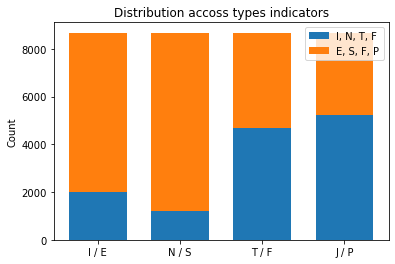

In [5]:
#Plotting the distribution of each personality type indicator
N = 4
bottom = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
# the width of the bars
width = 0.7           # or len(x) can also be used here

p1 = plt.bar(ind, bottom, width, label="I, N, T, F")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P") 

plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E',  'N / S', 'T / F', 'J / P',))
plt.legend()

plt.show()

<AxesSubplot:title={'center':'Features Correlation Heatmap'}>

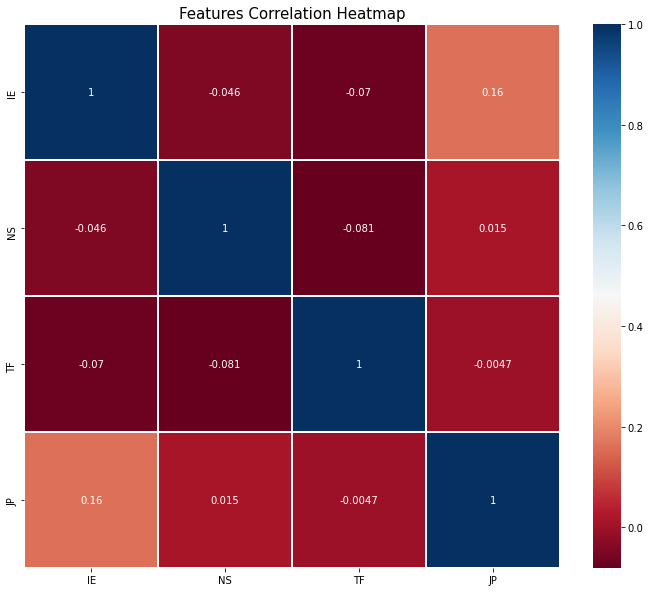

In [6]:
cmap = plt.cm.RdBu
corr = data[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(12,10))
plt.title('Features Correlation Heatmap', size=15)
sns.heatmap(corr, cmap=cmap,  annot=True, linewidths=1)

In [7]:
lemmatiser = WordNetLemmatizer()

# Remove the stop words for speed 
useless_words = stopwords.words("english")

# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]

# Or we can use Label Encoding (as above) of this unique personality type indicator list
# from sklearn.preprocessing import LabelEncoder
# unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
#        'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
# lab_encoder = LabelEncoder().fit(unique_type_list)

In [8]:
lemmatiser = WordNetLemmatizer()

# Remove the stop words for speed 
useless_words = stopwords.words("english")

# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]

# Or we can use Label Encoding (as above) of this unique personality type indicator list
# from sklearn.preprocessing import LabelEncoder
# unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
#        'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
# lab_encoder = LabelEncoder().fit(unique_type_list)

In [9]:
# Splitting the MBTI personality into 4 letters and binarizing it

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [b_Pers[l] for l in personality]

#To show result output for personality prediction
def translate_back(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [10]:
def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_data = len(data)
  i=0
  
  for row in data.iterrows():
      # check code working 
      # i+=1
      # if (i % 500 == 0 or i == 1 or i == len_data):
      #     print("%s of %s rows" % (i, len_data))

      #Remove and clean comments
      posts = row[1].posts

      #Remove url links 
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

      #Remove Non-words - keep only words
      temp = re.sub("[^a-zA-Z]", " ", temp)

      # Remove spaces > 1
      temp = re.sub(' +', ' ', temp).lower()

      #Remove multiple letter repeating words
      temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

      #Remove stop words
      if remove_stop_words:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
      else:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
          
      #Remove MBTI personality words from posts
      if remove_mbti_profiles:
          for t in unique_type_list:
              temp = temp.replace(t,"")

      # transform mbti to binary vector
      type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
      list_personality.append(type_labelized)
      # the cleaned data temp is passed here
      list_posts.append(temp)

  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

list_posts, list_personality  = pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", data.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", data.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])


Example :

Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/up

In [11]:
nRow, nCol = list_personality.shape
print(f'No. of posts = {nRow}  and No. of Personalities = {nCol} ')

No. of posts = 8675  and No. of Personalities = 4 


In [12]:
# Vectorizing the database posts to a matrix of token counts for the model
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1000,  
                             max_df=0.7,
                             min_df=0.1) 
# the feature should be made of word n-gram 
# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_posts)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage :-
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'across'), (4, 'act'), (5, 'action'), (6, 'actually'), (7, 'add'), (8, 'advice'), (9, 'afraid')]

Using Tf-idf :
Now the dataset size is as below
(8675, 595)


In [13]:
#counting top 10 words
reverse_dic = {}
for key in cntizer.vocabulary_:
    reverse_dic[cntizer.vocabulary_[key]] = key
top_10 = np.asarray(np.argsort(np.sum(X_cnt, axis=0))[0,-10:][0, ::-1]).flatten()
[reverse_dic[v] for v in top_10]

['feel',
 'type',
 'well',
 'say',
 'way',
 'friend',
 'want',
 'love',
 'good',
 'something']

In [14]:
personality_type = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", 
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])


IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)


In [15]:
print("X: 1st posts in tf-idf representation\n%s" % X_tfidf[0])


X: 1st posts in tf-idf representation
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.08105478 0.07066064
 0.         0.         0.         0.         0.         0.
 0.         0.04516864 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05321691 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0871647  0.         0.         0.
 0.         0.         0.         0.05506308 0.0708757  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.16585935 0.         0.         0.09676192 0.
 0.         0.04970682 0.         0.         0.         0.
 0.07397056 0.         0.         0.         0.         0.
 0.       

In [16]:
print("For MBTI personality type : %s" % translate_back(list_personality[0,:]))
print("Y : Binarized MBTI 1st row: %s" % list_personality[0,:])

For MBTI personality type : INFJ
Y : Binarized MBTI 1st row: [0 0 0 0]


In [17]:
# Posts in tf-idf representation
X = X_tfidf

In [18]:
import pickle
# Logistic Regression for MBTI dataset
# Individually training each mbti personlity type
result = []
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = LogisticRegression() 
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))
    result.append(y_pred)
pickle.dump(result,open('model.pkl','wb'))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.54%
NS: Intuition (N) / Sensing (S) Accuracy: 86.06%
FT: Feeling (F) / Thinking (T) Accuracy: 72.44%
JP: Judging (J) / Perceiving (P) Accuracy: 64.51%


In [19]:
my_posts  = """ Hi I am 21 years, currently, I am pursuing my graduate degree in computer science and management (Mba Tech CS ), It is a 5-year dual degree.... My CGPA to date is 3.8/4.0 . I have a passion for teaching since childhood. Math has always been the subject of my interest in school. Also, my mother has been one of my biggest inspirations for me. She started her career as a teacher and now has her own education trust with preschools schools in Rural and Urban areas. During the period of lockdown, I dwelled in the field of blogging and content creation on Instagram.  to spread love positivity kindness . I hope I am able deliver my best to the platform and my optimistic attitude helps in the growth that is expected. Thank you for the opportunity. """


mydata = pd.DataFrame(data={'type': ['INFJ'], 'posts': [my_posts]})

my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [20]:
param = {}
param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

#XGBoost model for MBTI dataset
result = []
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    print("%s classifier trained" % (personality_type[l]))
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])


IE: Introversion (I) / Extroversion (E) classifier trained
NS: Intuition (N) / Sensing (S) classifier trained
FT: Feeling (F) / Thinking (T) classifier trained
JP: Judging (J) / Perceiving (P) classifier trained


In [21]:
""""if translate_back(result)=='INFJ':
    print("Very high openness, mid conscientiousness, low to mid extroversion, very high agreeableness, high to very high neuroticism")
elif translate_back(result)=='ISTJ':
    print("Low to mid Openness, very high conscientiousness, low extroversion, low to mid agreeableness, mid neuroticism.")
elif translate_back(result)=='ISFJ':
    print("Low openness, high conscientiousness, mid extroversion, high agreeableness, high to very high neuroticism")
elif translate_back(result)=='ESTJ':
    print("Low openness, very high conscientiousness, mid to high extroversion, low agreeableness, low to mid neuroticism")
elif translate_back(result)=='ESFJ':
    print("Low openness, high conscientiousness, high extroversion, high agreeableness, mid to high neuroticism")
elif translate_back(result)=='ISTP':
    print("Mid openness, mid conscientiousness, low extroversion, low agreeableness, low neuroticism")
elif translate_back(result)=='ISFP':
    print("Mid to high openness, low conscientiousness, low extroversion, mid agreeableness, mid neuroticism")
elif translate_back(result)=='ESTP':
    print("Low to mid openess, low conscientiousness, very high extroversion, low to mid agreeableness, very low neuroticism")
elif translate_back(result)=='ESFP':
    print("Low to mid openness, low conscientiousness, very high extroversion, mid agreeableness, low neuroticism")
elif translate_back(result)=='INTJ':
    print("Very high openness, high conscientiousness, very low extroversion, low to mid agreeableness, mid to high neuroticism")
elif translate_back(result)=='ENTJ':
    print("Mid openness, high conscientiousness, mid to high extroversion, very low agreeableness, low neuroticism")
elif translate_back(result)=='ENFJ':
    print("Mid to high openness, low to mid conscientiousness, very high extroversion, mid to high agreeableness, low neuroticism")
elif translate_back(result)=='INTP':
    print("High openness, low conscientiousness, very low to low extroversion, low agreeableness, mid neuroticism")
elif translate_back(result)=='INFP':
    print("High to very high openness, very low conscientiousness, low extroversion, mid openness, mid to high neuroticism")
elif translate_back(result)=='ENTP':
    print("Very high openness, very low conscientiousness, mid to high extroversion, low to mid agreeableness, low to mid neuroticism")
elif translate_back(result)=='ENFP':
    print("Very high openness, very low conscientiousness, mid to high extroversion, mid agreeableness, mid neuroticism")

    """""

Very high openness, mid conscientiousness, low to mid extroversion, very high agreeableness, high to very high neuroticism
